### 只利用Tensor和autograd来实现一个线性回归的训练。

#### 生成数据集

In [1]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

+ 构造一个简单的人工训练数据集，以便直观比较学到的参数和真实的模型参数的区别。

In [2]:
# 设训练数据集样本数为1000，输入个数（特征数）为2。给定随机生成的批量样本特征。
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs,
                       dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)

In [3]:
print(features[0], labels[0])

tensor([-0.5904,  0.9607]) tensor(-0.2542)


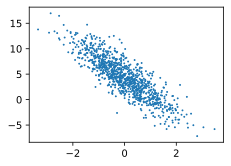

In [4]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize
# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 
set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

#### 读取数据

In [5]:
# 在训练模型时需要遍历数据集并不断读取小批量数据样本。
# 定义一个函数：每次返回batch_size（批量大小）个随机样本的特征和标签

# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)

In [6]:
# 读取第一个小批量数据样本并打印。每个批量的特征形状为(10, 2)，分别对应批量大小和输入个数；标签形状为批量大小。
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[ 0.4487,  1.0716],
        [ 0.7418, -1.4646],
        [-0.4756, -0.7498],
        [-0.6745, -0.1772],
        [-1.1773,  1.8614],
        [ 0.5786,  0.4451],
        [ 2.3027,  1.5930],
        [ 1.9502, -1.1264],
        [ 0.5924, -1.0253],
        [-1.0330, -0.4354]]) tensor([ 1.4518, 10.6682,  5.8034,  3.4619, -4.5064,  3.8426,  3.3899, 11.9219,
         8.8556,  3.6178])


#### 初始化模型参数

In [9]:
# 将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

In [10]:
# 之后的模型训练中，需要对这些参数求梯度来迭代参数的值，因此设置它们的requires_grad=True
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

#### 定义模型

In [11]:
def linreg(X, w, b):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    return torch.mm(X, w) + b

#### 定义损失函数

In [12]:
# 使用上一节描述的平方损失来定义线性回归的损失函数
# 在实现时需要把真实值y变形成预测值y_hat的形状
# 以下函数返回的结果也将和y_hat的形状相同
def squared_loss(y_hat, y):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

#### 定义优化算法

In [13]:
# 以下的sgd函数实现了上一节中介绍的小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数
# 这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

#### 训练模型

In [14]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.031385
epoch 2, loss 0.000115
epoch 3, loss 0.000052


In [15]:
# 比较学到的参数和用来生成训练集的真实参数
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 2.0005],
        [-3.4000]], requires_grad=True)
4.2 
 tensor([4.1994], requires_grad=True)
